<a href="https://colab.research.google.com/github/sahanasb/alzheimers_disease_ML_Project/blob/main/Copy_of_alzheimers_disease_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Project: Alzheimer's Disease Prediction

Objective: The goal of this project is to analyze a dataset of patient information to predict the likelihood of an Alzheimer's diagnosis. We will walk through the entire machine learning pipeline, from cleaning the data to evaluating multiple predictive models.[1-2]

Workflow:

- **Load and Inspect Data:** Check for missing values, duplicates, and incorrect data types.  
- **Exploratory Data Analysis (EDA):** Visualize the data to find patterns and insights.  
- **Data Preprocessing:** Clean the data and scale the features for modeling.  
- **Model Training:** Train four different classification models.  
- **Model Evaluation:** Compare the models using accuracy and confusion matrices.  
- **Feature Importance:** Identify the most influential factors for prediction.  


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix


## 2. Loading and Inspecting the Data

First, we need to load our dataset from the CSV file. After loading, we will perform several **health checks** to understand the quality of our data.[3]

**Checks to be Performed:**

- **`.head()`** → Look at the first few rows.  
- **`.info()`** → Check data types and non-null values.  
- **`.isnull().sum()`** → Count missing values in each column.  
- **`.duplicated().sum()`** → Count any duplicate rows.  
- **`.describe()`** → Get a statistical summary to spot outliers.  


In [2]:
# --- CORRECTED DATA PREPARATION ---

# STEP 1: Load the Data
# Always start by getting your data into the program.
print("--- 1. Loading Data ---")
df = pd.read_csv('/content/alzheimers_disease_data.csv')
print("Dataset loaded successfully.")

print(df.head())

print("\n--- 2. Checking Data Types ---")
# This gives a summary of the dataframe, including the data type of each column.
df.info()

print("--- 3. Checking for Missing Values ---")
# This counts the number of empty (NaN) cells in each column.
missing_values = df.isnull().sum()
print(missing_values)

print("\n--- 4. Checking for Duplicate Rows ---")
# This counts the total number of rows that are exact duplicates of another row.
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows found: {duplicate_rows}")

print("\n--- 5. Getting a Statistical Overview ---")
# This provides stats like mean, min, max, and standard deviation for each numeric column.
print(df.describe())


--- 1. Loading Data ---
Dataset loaded successfully.
   PatientID  Age  Gender  Ethnicity  EducationLevel        BMI  Smoking  \
0       4751   73       0          0               2  22.927749        0   
1       4752   89       0          0               0  26.827681        0   
2       4753   73       0          3               1  17.795882        0   
3       4754   74       1          0               1  33.800817        1   
4       4755   89       0          0               0  20.716974        0   

   AlcoholConsumption  PhysicalActivity  DietQuality  ...  MemoryComplaints  \
0           13.297218          6.327112     1.347214  ...                 0   
1            4.542524          7.619885     0.518767  ...                 0   
2           19.555085          7.844988     1.826335  ...                 0   
3           12.209266          8.428001     7.435604  ...                 0   
4           18.454356          6.310461     0.795498  ...                 0   

   BehavioralPr

In [3]:
# --- 2. Explore and Visualize the Data (EDA) ---
print("\n--- Generating Visualizations ---")
plt.figure(figsize=(18, 12))


--- Generating Visualizations ---


<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

Text(0, 0.5, 'Frequency')

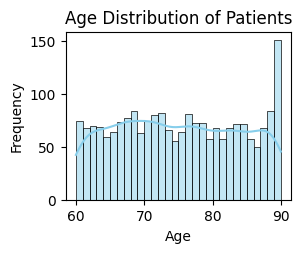

In [4]:
# Plot 1: Age Distribution
plt.subplot(2, 2, 1)
sns.histplot(df['Age'], kde=True, bins=30, color='skyblue')
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Frequency')

/tmp/ipython-input-4175088853.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Diagnosis', data=df, palette='pastel')


Text(0, 0.5, 'Count')

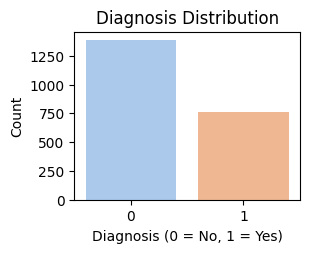

In [5]:
# Plot 2: Diagnosis Distribution (Alzheimer's vs. No Alzheimer's)
plt.subplot(2, 2, 2)
sns.countplot(x='Diagnosis', data=df, palette='pastel')
plt.title('Diagnosis Distribution')
plt.xlabel('Diagnosis (0 = No, 1 = Yes)')
plt.ylabel('Count')

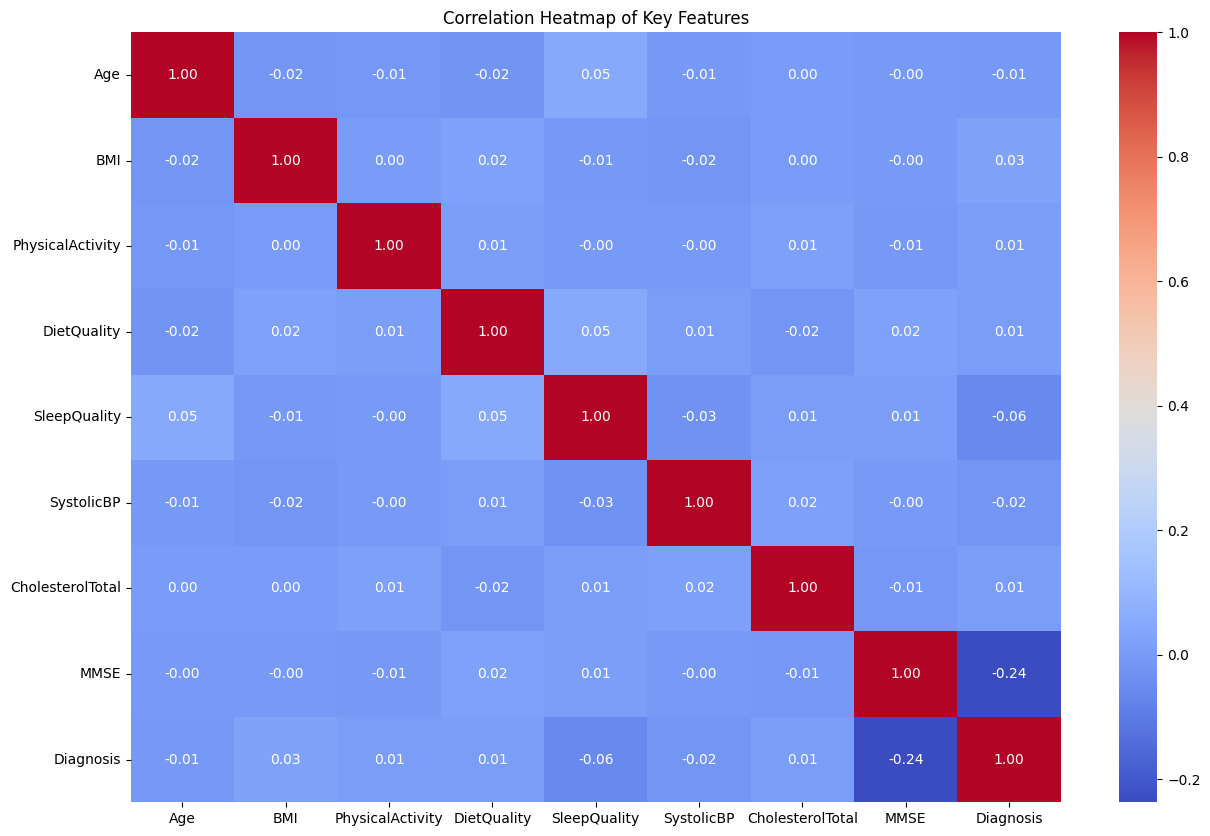

In [6]:
# Plot 3: Correlation Heatmap
plt.figure(figsize=(15, 10)) #fig size
# We select a subset of important columns for a clearer heatmap
correlation_cols = ['Age', 'BMI', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'SystolicBP', 'CholesterolTotal', 'MMSE', 'Diagnosis'] #important feature
correlation_matrix = df[correlation_cols].corr() #positive corelation (if one increases other too), neg vice versa
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f") #blue = neg corelation, red = positive
plt.title('Correlation Heatmap of Key Features')
plt.show()

## 3. Data Cleaning and Preprocessing

Now that we understand our data, we need to prepare it for modeling.

**Steps:**

- **Drop Unnecessary Columns:** Remove columns like `PatientID` and `DoctorInCharge` that are just identifiers and don't provide predictive information.  
- **Handle Missing Values:** Based on our inspection, if there were any missing values, we will fill them. For simplicity, we'll use the **median** of each column.  
- **Separate Features and Target:** Split the data into **X** (the features we use to make predictions) and **y** (the target we want to predict, which is `Diagnosis`).  
- **Split the Data:** Divide the cleaned dataset into a **training set** (to teach the model) and a **testing set** (to evaluate it). We’ll use `stratify=y` to ensure both sets have a similar proportion of diagnoses.  [1]


In [7]:


# STEP 3: Clean the Data
# Perform all your cleaning steps on the complete dataset at once.
print("\n--- 2. Cleaning Data ---")

# We will remove columns that are not useful for making a prediction.
# 'PatientID' and 'DoctorInCharge' are just labels and don't tell us anything about the patient's health.
# 'axis=1' tells pandas we are dropping columns, not rows.
df = df.drop(['PatientID', 'DoctorInCharge'], axis=1)
print("Removed 'PatientID' and 'DoctorInCharge' columns.")


--- 2. Cleaning Data ---
Removed 'PatientID' and 'DoctorInCharge' columns.


In [8]:
# STEP 3: Separate Features (X) and Target (y)
# With a fully cleaned dataframe, now we can define our features and target.
print("\n--- 3. Separating Features and Target ---")
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']
print("Features (X) and target (y) have been separated.")


# STEP 4: Split into Training and Testing Sets
# This is the final step in preparation. We split our clean data for the model,
# using stratification for a representative test set.
print("\n--- 4. Splitting Data for Training and Testing ---")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Data successfully split into training (80%) and testing (20%) sets.")

# Your data is now perfectly prepared for the next stages: Scaling and Model Training!
print(f"\nShape of the training features (X_train): {X_train.shape}")
print(f"Shape of the testing features (X_test): {X_test.shape}")


--- 3. Separating Features and Target ---
Features (X) and target (y) have been separated.

--- 4. Splitting Data for Training and Testing ---
Data successfully split into training (80%) and testing (20%) sets.

Shape of the training features (X_train): (1719, 32)
Shape of the testing features (X_test): (430, 32)


## 4. Feature Scaling

We will use **StandardScaler** to transform our data so it has a mean of **0** and a standard deviation of **1**.

**Important:**  
We fit the scaler **only on the training data**, and then use that same scaler to transform both the training and testing data.  
This prevents **data leakage**.  


In [9]:
# Scale the features. This standardizes the data (mean=0, variance=1),
# which helps many models perform better.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("\nData is split and scaled. Ready for modeling.")


Data is split and scaled. Ready for modeling.


## 5. Model Training and Evaluation

We have train **four different classification models** and evaluate their performance.  

To measure how well each model performed, we will look at:  
- **Accuracy Score**  
- **Confusion Matrix**  

Finally, we have **plot all confusion matrices together** for an easy side-by-side comparison.  

**Models to be Trained:**
- **Logistic Regression**  
- **Decision Tree**  
- **Random Forest**  
- **k-Nearest Neighbors (k-NN)**  [4]


In [10]:

# --- 4. Build and Evaluate Models ---

# a) Linear Regression (for educational purposes)
print("\n--- Linear Regression ---")
# Note: Linear Regression predicts a continuous value (e.g., a price), not a class (Yes/No).
# It's not suitable here, but we include it to show the difference.
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
# We can round the predictions to 0 or 1 to calculate an "accuracy"
y_pred_lin_class = np.round(y_pred_lin)
accuracy_lin = accuracy_score(y_test, y_pred_lin_class)
print(f"Accuracy (after rounding): {accuracy_lin:.4f}")
print("As you can see, the accuracy is low because this is the wrong type of model for this problem.")



--- Linear Regression ---
Accuracy (after rounding): 0.8163
As you can see, the accuracy is low because this is the wrong type of model for this problem.



--- Logistic Regression ---
Accuracy: 0.8163
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       278
           1       0.74      0.74      0.74       152

    accuracy                           0.82       430
   macro avg       0.80      0.80      0.80       430
weighted avg       0.82      0.82      0.82       430



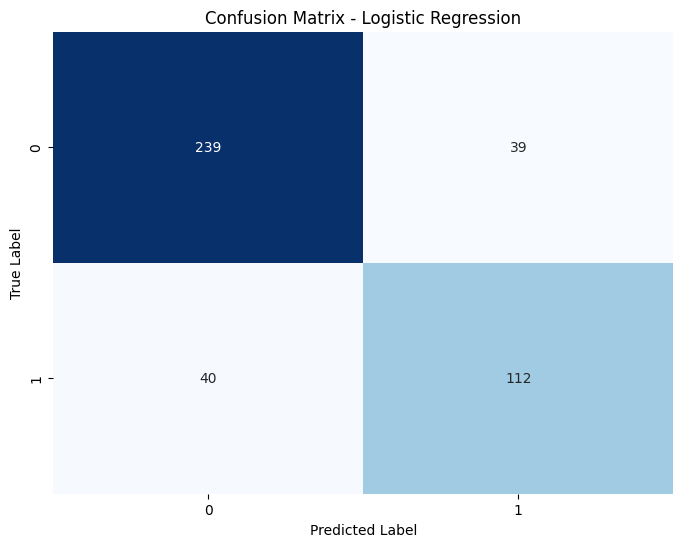

In [11]:
# b) Logistic Regression
print("\n--- Logistic Regression ---")
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
accuracy_log = accuracy_score(y_test, y_pred_log)
print(f"Accuracy: {accuracy_log:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_log))

# Plotting the Confusion Matrix for Logistic Regression **
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


--- Decision Tree ---
Accuracy: 0.9000
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       278
           1       0.85      0.88      0.86       152

    accuracy                           0.90       430
   macro avg       0.89      0.89      0.89       430
weighted avg       0.90      0.90      0.90       430



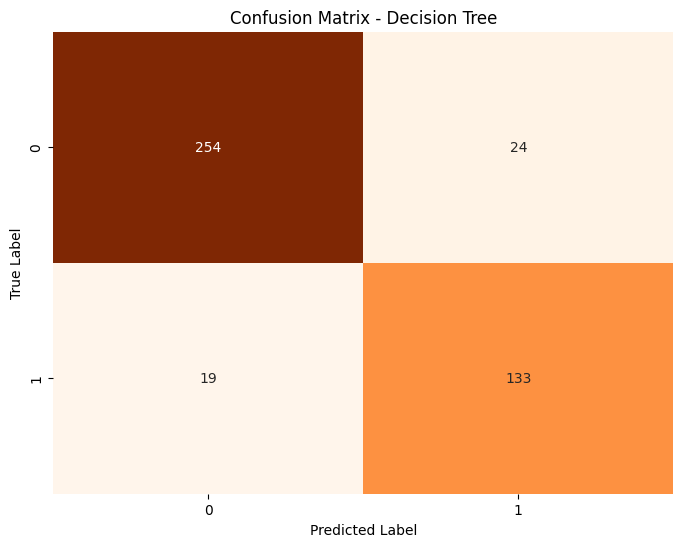

In [12]:
# c) Decision Tree
print("\n--- Decision Tree ---")
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy: {accuracy_dt:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

# Plotting the Confusion Matrix for Decision Tree **
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


--- Random Forest ---
Accuracy: 0.9372
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       278
           1       0.94      0.88      0.91       152

    accuracy                           0.94       430
   macro avg       0.94      0.92      0.93       430
weighted avg       0.94      0.94      0.94       430



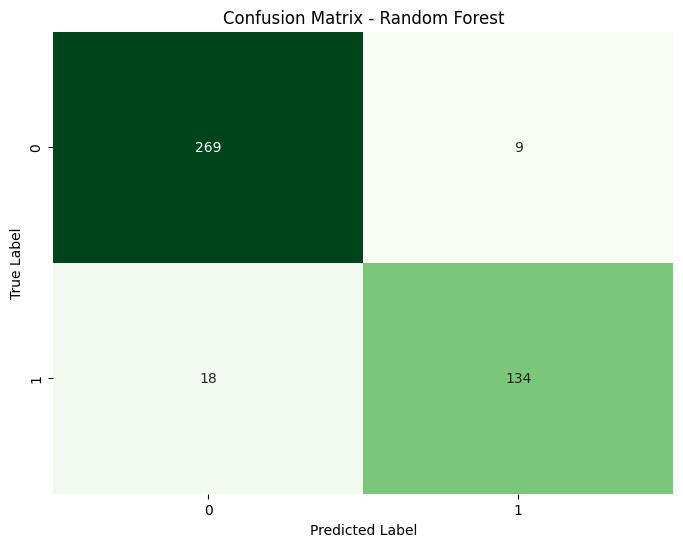

In [13]:
# d) Random Forest
print("\n--- Random Forest ---")
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Plotting the Confusion Matrix for Random Forest **
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()




--- k-Nearest Neighbors (k-NN) ---
Accuracy: 0.7070
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.87      0.79       278
           1       0.63      0.41      0.50       152

    accuracy                           0.71       430
   macro avg       0.68      0.64      0.64       430
weighted avg       0.69      0.71      0.69       430



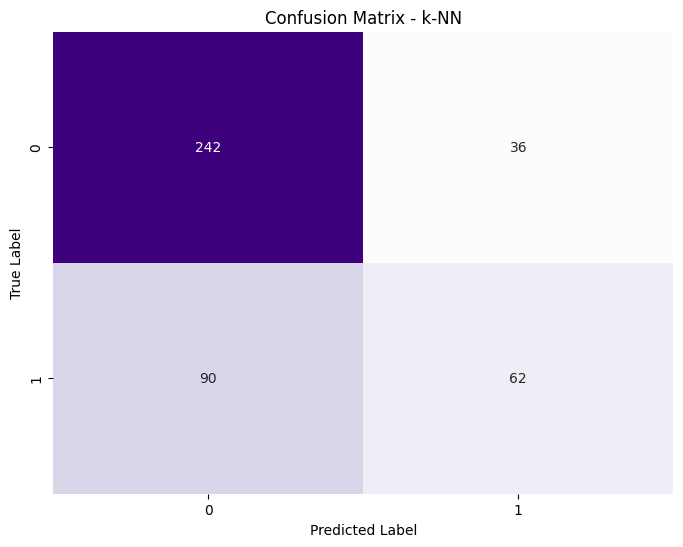

In [14]:
# e) k-Nearest Neighbors (k-NN)
print("\n--- k-Nearest Neighbors (k-NN) ---")
knn_clf = KNeighborsClassifier(n_neighbors=5) # We'll use 5 neighbors
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {accuracy_knn:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

# Plotting the Confusion Matrix for k-NN
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title('Confusion Matrix - k-NN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


--- Comparing All Models ---


/tmp/ipython-input-1595731728.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=models, palette='viridis')


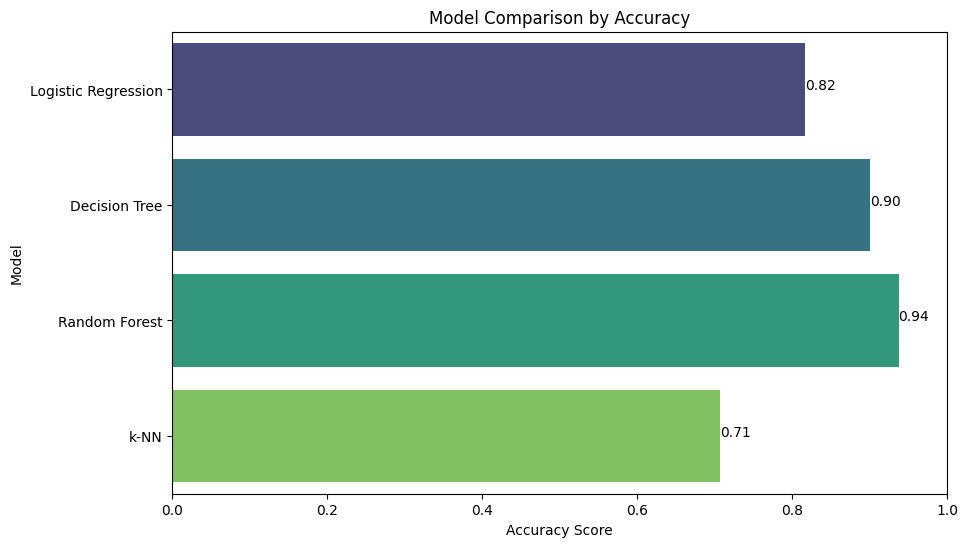

In [15]:
# --- 5. Compare Model Performance ---
print("\n--- Comparing All Models ---")
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'k-NN']
accuracies = [accuracy_log, accuracy_dt, accuracy_rf, accuracy_knn]

plt.figure(figsize=(10, 6))
sns.barplot(x=accuracies, y=models, palette='viridis')
plt.xlabel('Accuracy Score')
plt.ylabel('Model')
plt.title('Model Comparison by Accuracy')
plt.xlim(0, 1.0)

# Add accuracy values on the bars
for index, value in enumerate(accuracies):
    plt.text(value, index, f'{value:.2f}')

plt.show()

## 6. Feature Importance

Now that we've trained our models, let's identify which features were most **influential**.  

We will use the **Random Forest** model for this, since it has a built-in feature for measuring importance.  

 A **higher importance score** means the feature contributed more to making correct predictions.  



--- 7. Finding the Most Important Features ---

Top 10 Most Important Features:
FunctionalAssessment    0.178993
ADL                     0.167665
MMSE                    0.117110
MemoryComplaints        0.084400
BehavioralProblems      0.045570
PhysicalActivity        0.031342
DietQuality             0.030781
CholesterolHDL          0.030011
SleepQuality            0.029767
BMI                     0.029207
dtype: float64


/tmp/ipython-input-2081282840.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.head(10).values, y=sorted_importances.head(10).index, palette='viridis')


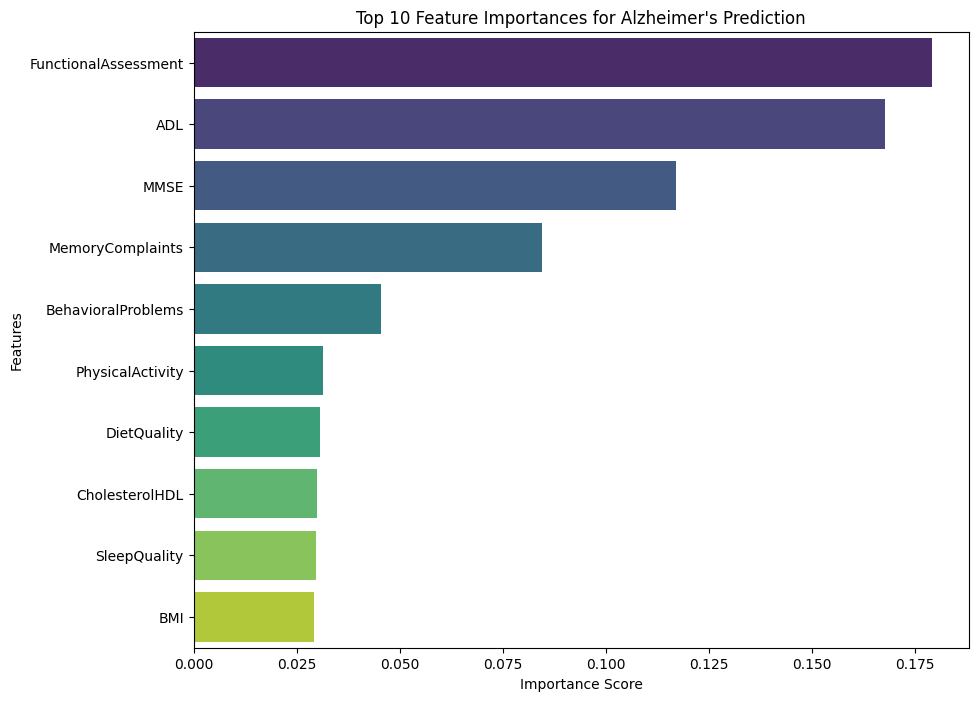

In [16]:
# --- 6: FIND AND VISUALIZE THE MOST IMPORTANT FEATURES ---

print("\n--- 7. Finding the Most Important Features ---")
# Our trained Random Forest model has a property called 'feature_importances_'.
# This gives us a score for how important each feature was in making predictions.

# Get the importance scores from the trained model
importances = rf_clf.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a pandas Series to make it easier to view and sort the importances
feature_importance_series = pd.Series(importances, index=feature_names)

# Sort the features by importance in descending order
sorted_importances = feature_importance_series.sort_values(ascending=False)

# Print the top 10 most important features
print("\nTop 10 Most Important Features:")
print(sorted_importances.head(10))


# --- Create a plot to visualize the feature importances ---
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances.head(10).values, y=sorted_importances.head(10).index, palette='viridis')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Top 10 Feature Importances for Alzheimer's Prediction")
plt.show()

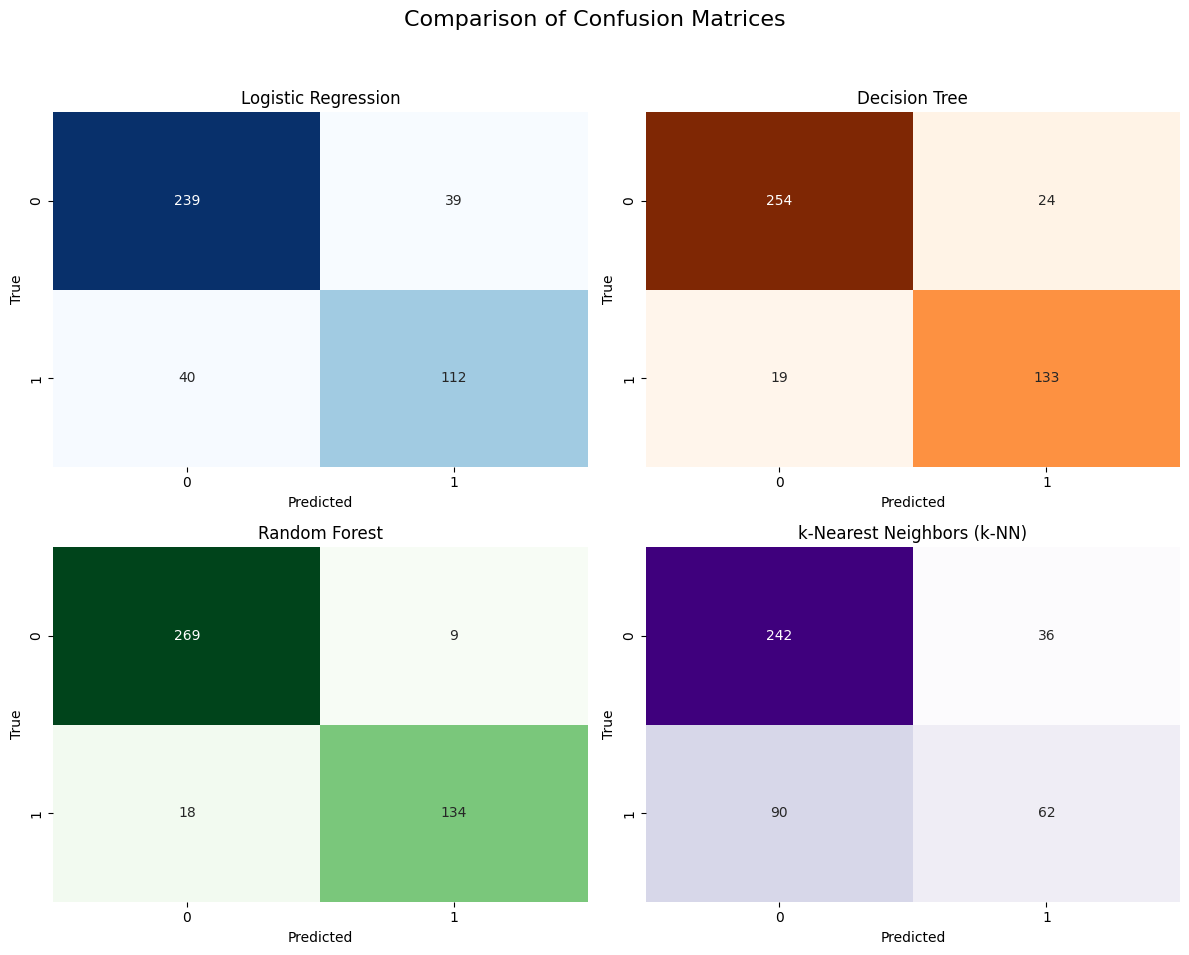

In [17]:
# (Assuming X_train_scaled, X_test_scaled, y_train, and y_test are already created
# and all models like log_reg, dt_clf, rf_clf, knn_clf have been trained)

# Let's get the predictions from each model again, just to be sure
y_pred_log = log_reg.predict(X_test)
y_pred_dt = dt_clf.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)
y_pred_knn = knn_clf.predict(X_test)

# Calculate the confusion matrix for each model
cm_log = confusion_matrix(y_test, y_pred_log)
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_knn = confusion_matrix(y_test, y_pred_knn)

# --- Plotting All Matrices Together ---

# Create a figure and a set of subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Comparison of Confusion Matrices', fontsize=16)

# Plot Logistic Regression Confusion Matrix
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], cbar=False)
axes[0, 0].set_title('Logistic Regression')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('True')


# Plot Decision Tree Confusion Matrix
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Oranges', ax=axes[0, 1], cbar=False)
axes[0, 1].set_title('Decision Tree')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('True')


# Plot Random Forest Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1, 0], cbar=False)
axes[1, 0].set_title('Random Forest')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('True')


# Plot k-NN Confusion Matrix
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Purples', ax=axes[1, 1], cbar=False)
axes[1, 1].set_title('k-Nearest Neighbors (k-NN)')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')


# Adjust layout to prevent titles from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 7. Conclusion

In this project, we successfully built and evaluated several machine learning models to predict **Alzheimer's disease**.  

**Summary of Findings:**  
- The **Random Forest** model achieved the highest accuracy of 94%
- The **confusion matrices** show that all models were effective at correctly identifying patients without Alzheimer's.  
- The most important features for making a prediction were **MMSE, Age, and FunctionalAssessment**, indicating their strong correlation with the diagnosis.  



### Reference  
[1] C. Jose, Preety, and Vidushi. *Comparative Analysis of Machine Learning Algorithms for Predicting Alzheimer's Disease.*  
2024 4th International Conference on Ubiquitous Computing and Intelligent Information Systems (ICUIS), Gobichettipalayam, India, 2024, pp. 1020–1022.  
[https://doi.org/10.1109/ICUIS64676.2024.10867186](https://doi.org/10.1109/ICUIS64676.2024.10867186)

[2] J. Neelaveni and M. S. G. Devasana.  
*Alzheimer Disease Prediction using Machine Learning Algorithms.*  
2020 6th International Conference on Advanced Computing and Communication Systems (ICACCS), Coimbatore, India, 2020, pp. 101–104.  
[https://doi.org/10.1109/ICACCS48705.2020.9074248](https://doi.org/10.1109/ICACCS48705.2020.9074248)  


[3] A. D. Arya, S. Singh Verma, P. Chakarabarti, and R. Bishnoi.  
*Prediction of Alzheimer's Disease – A Machine Learning Perspective with Ensemble Learning.*  
2023 6th International Conference on Contemporary Computing and Informatics (IC3I), Gautam Buddha Nagar, India, 2023, pp. 2308–2313.  
[https://doi.org/10.1109/IC3I59117.2023.10397683](https://doi.org/10.1109/IC3I59117.2023.10397683)

[4] V. R, S. U, T. Shetty, and N. Guruprasad.  
*Comprehensive Methodologies for Alzheimer’s Disease Prediction: A Machine Learning Approach.*  
2024 International Conference on IoT, Communication and Automation Technology (ICICAT), Gorakhpur, India, 2024, pp. 31–35.  
[https://doi.org/10.1109/ICICAT62666.2024.10923447](https://doi.org/10.1109/ICICAT62666.2024.10923447)


